In [291]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations
import statsmodels.api as sm


In [292]:
phase_dir = '../phased_ihart.ms2_quads_del'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
assembly = '38'

#phase_dir = '../phased_spark_quads_del'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#assembly = '38'

In [293]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
			if pieces[2] != '0' and pieces[3] != '0':
				parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children
sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

In [294]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths37 = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
#	'X': 155270560,
#	'Y': 59373566
}

# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths38 = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
#	'X': 156040895,
#	'Y': 57227415
}

if assembly == '38':
    chrom_lengths = chrom_lengths38
else:
    chrom_lengths = chrom_lengths37

In [295]:
cyto = []
with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    next(f)
    for line in f:
        pieces = line.strip().split('\t')
        cyto.append((pieces[0], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))



In [296]:
child_to_crossovers = defaultdict(list)
already_included = set()

# preferentially pull aut-aut and nt-nt sibpairs
for file in sorted(os.listdir(phase_dir)):
    if file.endswith('.crossovers.json'):
        with open('%s/%s' % (phase_dir, file), 'r') as f:
            cos = json.load(f)
            if cos[0]['child'][0] in already_included or cos[0]['child'][1] in already_included:
                pass
                #print('Child(ren) already included in analysis', cos[0]['child'][0], cos[0]['child'][1], file)
            elif sample_to_affected[cos[0]['child'][0]]==sample_to_affected[cos[0]['child'][1]]:
                for co in cos:
                    child_to_crossovers[tuple(co['child'])].append(co)
                already_included.add(co['child'][0])
                already_included.add(co['child'][1])

for file in sorted(os.listdir(phase_dir)):
    if file.endswith('.crossovers.json'):
        with open('%s/%s' % (phase_dir, file), 'r') as f:
            cos = json.load(f)
            if cos[0]['child'][0] in already_included or cos[0]['child'][1] in already_included:
                pass
                #print('Child(ren) already included in analysis', cos[0]['child'][0], cos[0]['child'][1], file)
            else:
                for co in cos:
                    child_to_crossovers[tuple(co['child'])].append(co)
                already_included.add(co['child'][0])
                already_included.add(co['child'][1])
            
print(len(child_to_crossovers))

908


In [297]:
# remove outliers
children = sorted(child_to_crossovers.keys())
num_cos = np.array([len(child_to_crossovers[x]) for x in children])
num_mat_cos = np.array([len([y for y in child_to_crossovers[x] if y['is_mat']]) for x in children])
num_pat_cos = np.array([len([y for y in child_to_crossovers[x] if y['is_pat']]) for x in children])

co_med = np.median(num_cos)
co_mad = np.median(np.abs(num_cos-co_med))
co_cutoff = co_mad*4/0.6745

mat_co_med = np.median(num_mat_cos)
mat_co_mad = np.median(np.abs(num_mat_cos-mat_co_med))
mat_co_cutoff = mat_co_mad*4/0.6745

pat_co_med = np.median(num_pat_cos)
pat_co_mad = np.median(np.abs(num_pat_cos-pat_co_med))
pat_co_cutoff = pat_co_mad*4/0.6745

is_outlier = (num_cos>co_med+co_cutoff) | (num_cos<co_med-co_cutoff) | \
    (num_mat_cos>mat_co_med+mat_co_cutoff) | (num_mat_cos<mat_co_med-mat_co_cutoff) | \
    (num_pat_cos>pat_co_med+pat_co_cutoff) | (num_pat_cos<pat_co_med-pat_co_cutoff)
print('removing outliers', np.sum(is_outlier))

for i in np.where(is_outlier)[0]:
    del child_to_crossovers[children[i]]
print(len(child_to_crossovers))

removing outliers 9
899


In [298]:
aut_crossovers = []
nt_crossovers = []
autnt_crossovers = []
for child, crossovers in child_to_crossovers.items():
    if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2':
        aut_crossovers.extend(crossovers)
    elif sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1':
        nt_crossovers.extend(crossovers)
    elif (sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='2') or (sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='1'):
        autnt_crossovers.extend(crossovers)
        
print(len(aut_crossovers), len(nt_crossovers), len(autnt_crossovers))

108580 5820 11182


In [299]:
print(len([x for x in child_to_crossovers.keys() if sample_to_affected[x[0]]=='2' and sample_to_affected[x[1]]=='2']))
print(len([x for x in child_to_crossovers.keys() if sample_to_affected[x[0]]=='1' and sample_to_affected[x[1]]=='1']))
print(len([x for x in child_to_crossovers.keys() if sample_to_affected[x[0]]!=sample_to_affected[x[1]]]))




779
41
79


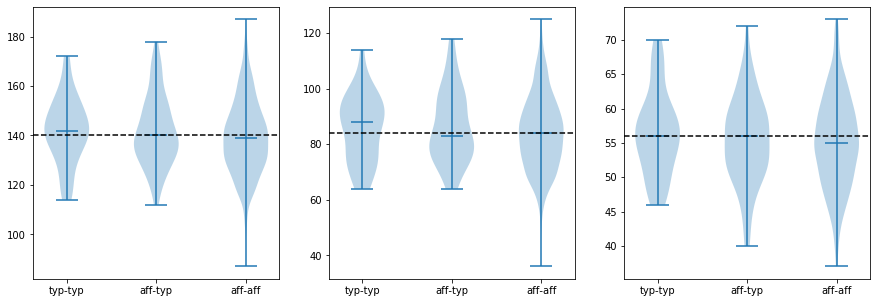

In [300]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.violinplot([[len(x) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1'],
                [len(x) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]!=sample_to_affected[child[1]]],
                [len(x) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2']],
              showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['typ-typ', 'aff-typ', 'aff-aff'])
plt.axhline(2*(28+42), color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.violinplot([[len([y for y in x if y['is_mat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1'],
                [len([y for y in x if y['is_mat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]!=sample_to_affected[child[1]]],
                [len([y for y in x if y['is_mat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2']],
               showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['typ-typ', 'aff-typ', 'aff-aff'])
plt.axhline(2*42, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.violinplot([[len([y for y in x if y['is_pat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1'],
                [len([y for y in x if y['is_pat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]!=sample_to_affected[child[1]]],
                [len([y for y in x if y['is_pat']]) for child, x in child_to_crossovers.items() if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2']],
               showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['typ-typ', 'aff-typ', 'aff-aff'])
plt.axhline(2*28, color='black', linestyle='--')

plt.show()

In [301]:
X = np.zeros((len(child_to_crossovers), 5))
y = -np.ones((len(child_to_crossovers),))
for i, (child, cos) in enumerate(child_to_crossovers.items()):
    X[i, 0] = len([c for c in cos if c['is_mat']])
    X[i, 1] = len([c for c in cos if c['is_pat']])
    X[i, 2] = int(sample_to_sex[child[0]]=='1' and sample_to_sex[child[1]]=='1')
    X[i, 3] = int(sample_to_sex[child[0]]=='2' and sample_to_sex[child[1]]=='2')
    X[i, 4] = 1
    if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2':
        y[i] = 1
    elif sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1':
        y[i] = 0
    
print(np.sum(y==1), np.sum(y==0))
model = sm.Logit(y[y!=-1], X[y!=-1, :])
results = model.fit(disp=False)
results.summary()


779 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  820
Model:                          Logit   Df Residuals:                      815
Method:                           MLE   Df Model:                            4
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.08926
Time:                        13:25:29   Log-Likelihood:                -148.25
converged:                       True   LL-Null:                       -162.78
Covariance Type:            nonrobust   LLR p-value:                 7.604e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0122      0.013     -0.964      0.335      -0.037       0.013
x2            -0.0311      0.024     -1.275      0.202      -0.079       0.017
x3             1.4402      0.393      3.666      0.000       0.670       2.210
x4            -0.8718      0.420     -2.073      0.038      -1.696      -0.048
const          5.2200      1.771      2.948      0.003       1.750       8.690
==============================================================================
"""

In [302]:
X = np.zeros((len(child_to_crossovers), 4))
y = -np.ones((len(child_to_crossovers),))
for i, (child, cos) in enumerate(child_to_crossovers.items()):
    X[i, 0] = len([c for c in cos])
    X[i, 1] = int(sample_to_sex[child[0]]=='1' and sample_to_sex[child[1]]=='1')
    X[i, 2] = int(sample_to_sex[child[0]]=='2' and sample_to_sex[child[1]]=='2')
    X[i, 3] = 1
    if sample_to_affected[child[0]]=='2' and sample_to_affected[child[1]]=='2':
        y[i] = 1
    elif sample_to_affected[child[0]]=='1' and sample_to_affected[child[1]]=='1':
        y[i] = 0
    
print(np.sum(y==1), np.sum(y==0))
model = sm.Logit(y[y!=-1], X[y!=-1, :])
results = model.fit(disp=False)
results.summary()


779 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  820
Model:                          Logit   Df Residuals:                      816
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.08779
Time:                        13:25:29   Log-Likelihood:                -148.49
converged:                       True   LL-Null:                       -162.78
Covariance Type:            nonrobust   LLR p-value:                 2.741e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0161      0.011     -1.446      0.148      -0.038       0.006
x2             1.4349      0.393      3.654      0.000       0.665       2.204
x3            -0.8826      0.420     -2.102      0.036      -1.706      -0.060
const          4.7306      1.614      2.931      0.003       1.568       7.893
==============================================================================
"""

In [325]:
positions = set()
for chrom in np.arange(1, 23):
    l = chrom_lengths[str(chrom)]
    cens = [x for x in cyto if x[0]=='chr%d'%chrom and x[4]=='acen']
    
    positions.add((chrom, 1))
    positions.add((chrom, cens[0][1]))
    positions.add((chrom, cens[-1][2]))
    positions.add((chrom, l))
    
    
positions = sorted(positions)
print(len(positions))

88


In [326]:
interval_lengths = np.array([0 if positions[i+1][0] != positions[i][0] else positions[i+1][1]-positions[i][1] for i in np.arange(len(positions)-1)])

In [327]:
p_autcross, p_ntcross = np.zeros((len(positions),)), np.zeros((len(positions),))
for chrom in range(1, 23):
    print(chrom, end=' ')
    indices = [i for i in np.arange(len(positions)-1) if positions[i][0]==chrom and positions[i+1][0]==chrom]
    for co in [x for x in aut_crossovers if x['chrom']==chrom and x['is_pat']]:
        for i in indices:
            overlap = min(positions[i+1][1], co['end_pos']) - max(positions[i][1], co['start_pos'])
            if overlap>0:
                p_autcross[i] += overlap/(co['end_pos']-co['start_pos'])
                
    for co in [x for x in nt_crossovers if x['chrom']==chrom and x['is_pat']]:
        for i in indices:
            overlap = min(positions[i+1][1], co['end_pos']) - max(positions[i][1], co['start_pos'])
            if overlap>0:
                p_ntcross[i] += overlap/(co['end_pos']-co['start_pos'])
p_autcross = p_autcross/len(aut_crossovers)
p_ntcross = p_ntcross/len(nt_crossovers)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

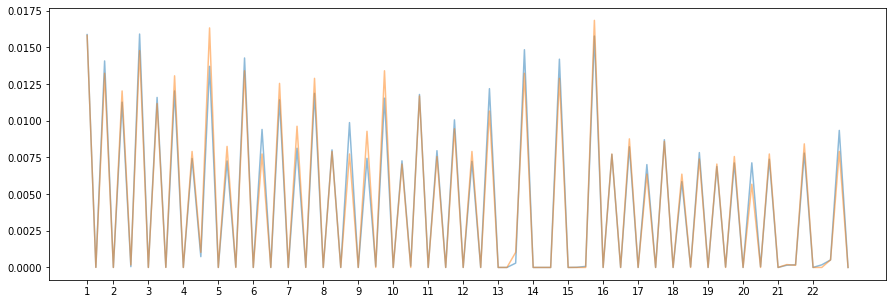

In [328]:
plt.figure(figsize=(15, 5))
plt.plot(p_autcross, alpha=0.5)
plt.plot(p_ntcross, alpha=0.5)
plt.xticks([0] + np.where([positions[i+1][0]!=positions[i][0] for i in np.arange(len(positions)-1)])[0].tolist(), 
          [str(x) for x in range(1, 23)])
plt.show()

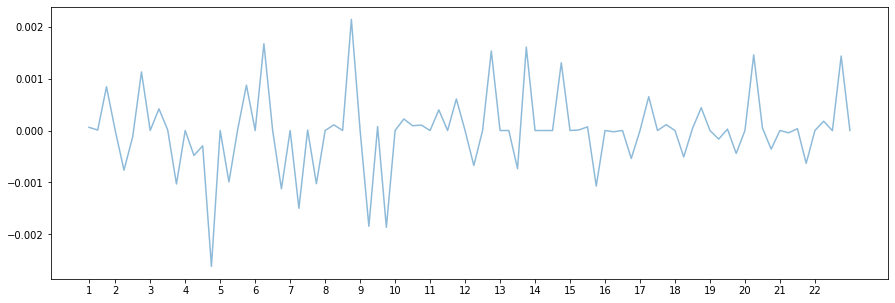

In [329]:
plt.figure(figsize=(15, 5))
plt.plot((p_autcross-p_ntcross), alpha=0.5)
plt.xticks([0] + np.where([positions[i+1][0]!=positions[i][0] for i in np.arange(len(positions)-1)])[0].tolist(), 
          [str(x) for x in range(1, 23)])
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


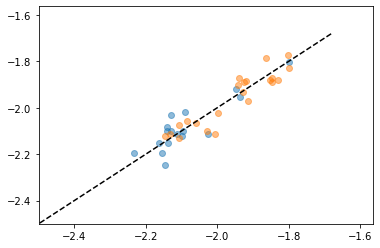

In [336]:
plt.scatter(np.log10(p_autcross[np.arange(0, 88, 4)]), np.log10(p_ntcross[np.arange(0, 88, 4)]), alpha=0.5)
plt.scatter(np.log10(p_autcross[np.arange(2, 88, 4)]), np.log10(p_ntcross[np.arange(2, 88, 4)]), alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlim([-2.5, None])
plt.ylim([-2.5, None])
plt.show()